First let's load the Jar. This requires `mill q.assembly` to be run beforehand.

In [1]:
interp.load.cp(os.pwd/".."/"out"/"q"/"assembly.dest"/"out.jar")

We will load some boilerplate code for graphing as well.

In [2]:
import $file.makeplot

import $file.$

Now, all the imports...

In [3]:
import riscq._
import riscq.tester.qubic._
import riscq.soc.QubicSoc
import riscq.tester._
import spinal.core.sim._
import spinal.core._
import spinal.lib.bus.tilelink.sim._
import spinal.lib.bus.tilelink._
import spinal.lib.bus.amba4.axi.sim.Axi4Master
import riscq.tester.RvAssembler
import riscq.tester.QubicAssembler
import riscq.tester.ByteHelper
import riscq.soc.QubicPlugins
import QubicTestConfig._
import scala.collection.mutable.ArrayBuffer
import spinal.lib._
import riscq.soc.MemoryMapSoc
import riscq.tester.RvAssembler
import riscq.tester.mmsoc.MMSocDriver

import riscq._
import riscq.tester.qubic._
import riscq.soc.QubicSoc
import riscq.tester._
import spinal.core.sim._
import spinal.core._
import spinal.lib.bus.tilelink.sim._
import spinal.lib.bus.tilelink._
import spinal.lib.bus.amba4.axi.sim.Axi4Master
import riscq.tester.RvAssembler
import riscq.tester.QubicAssembler
import riscq.tester.ByteHelper
import riscq.soc.QubicPlugins
import QubicTestConfig._
import scala.collection.mutable.ArrayBuffer
import spinal.lib._
import riscq.soc.MemoryMapSoc
import riscq.tester.RvAssembler
import riscq.tester.mmsoc.MMSocDriver

Some Gaussian nonsense...

In [4]:
def gaussian(width: Int, sigmas: Double = 3.0): Seq[Double] = {
  val sigma = width.toDouble / (2.0 * sigmas)
  val vals = (0 until width).map { i =>
    val x = i - width.toDouble / 2.0
    scala.math.exp(-(x * x) / (2 * sigma * sigma))
  }
  return vals
}

defined function gaussian

Now, time to collect some outputs.

In [5]:
val dac_output = ArrayBuffer[Double]()
val carrier_output = ArrayBuffer[Double]()
val simConfig = SimConfig.addSimulatorFlag("-Wno-MULTIDRIVEN")
simConfig.compile {
  val dut = MemoryMapSoc(withWhitebox = true)
  dut.pgs.map { _.io.simPublic() }
  dut.cgs.map { _.io.simPublic() }
  dut
}.doSim { dut =>
  val driver = new MMSocDriver(dut, "../src/main/asm/testMMSoc.elf")
  driver.init()

  // Is this the right place?
  val batchSize = 16
  val dataWidth = 16
  for (i <- 0 until 4) {
    val batch = List.tabulate(batchSize)((x : Int) => BigInt((5000 * gaussian(4 * batchSize)(i * batchSize + x)).toInt)).reverse
    val batchData = riscq.pulse.PGTestPulse.concat(batch, dataWidth)
    val dataStr = batch.map { x => ByteHelper.intToBinStr(x, dataWidth) }.reduce { _ ++ _ }
    driver.tlDriver.putFullData(0, i * batchSize * dataWidth / 8, ByteHelper.fromBinStr(dataStr).reverse)
  }
  driver.rstUp()
  driver.tick(50)
  driver.loadInsts()
  driver.rstDown()

  println("starting simulation...")
  driver.tick(100)
  for(_ <- 0 until 15) {
    val dac = dut.pgs(0).io.data
    val pulse = dac.payload.map { _.r.toDouble * (1 << 14) }.toList
    dac_output ++= pulse
    val carrier = dut.cgs(0).io.carrier
    val data = carrier.payload.map { _.r.toDouble * (1 << 14) }.toList
    carrier_output ++= data
    driver.tick()
  }
}

[Runtime] SpinalHDL dev    git head : bbe3c9911a233a5aa9672c70d237336385ab7dcc
[Runtime] JVM max memory : 3910.0MiB
[Runtime] Current date : 2025.04.05 12:54:55
[Progress] at 0.000 : Elaborate components
debug jumps: ArrayBuffer(toplevel/riscqArea_riscq/null)
########################1
debug hazard ctrlrange: Range 0 to 0
debug hazard ds: 0
!!!!!!!!!!!!!###########Range 0 until 2
!!!!!!!!!!!!!###########Range 0 until 2
[Progress] at 3.660 : Checks and transforms
[Progress] at 6.057 : Generate Verilog to ./simWorkspace/tmp/job_1
[Warning] toplevel/riscqArea_riscq/integer_RegFilePlugin_logic_regfile_fpga/asMem_ram : Mem[32*32 bits].readAsync can only be write first into Verilog
[Warning] toplevel/riscqArea_riscq/integer_RegFilePlugin_logic_regfile_fpga/asMem_ram : Mem[32*32 bits].readAsync can only be write first into Verilog
[Warning] toplevel/cd100mLogic_pulseMemWa_logic_bridge/upsize_d_ctx/contexts : Mem[16*3 bits].readAsync can only be write first into Verilog
[Warning] toplevel/riscq

dac_output: ArrayBuffer[Double] = ArrayBuffer(
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -54.0,
  -72.0,
  -94.0,
  -122.0,
  -155.0,
  -196.0,
  -245.0,
  -301.0,
  -366.0,
  -442.0,
  -524.0,
  -616.0,
  -716.0,
  -821.0,
  -930.0,
  -1040.0,
  -1147.0,
  -1249.0,
  -1340.0,
  -1417.0,
  -1475.0,
  -1510.0,
...
carrier_output: ArrayBuffer[Double] = ArrayBuffer(
  11583.0,
  12137.0,
  12662.0,
  13157.0,
  13620.0,
  14050.0,
  14447.0,
  14809.0,
  15134.0,
  15424.0,
  15676.0,
  15891.0,
  16067.0,
  16204.0,
  16302.0,
  16362.0,
  16382.0,
  16363.0,
  16303.0,
  16205.0,
  16067.0,
  15891.0,
  15677.0,
  15425.0,
  15135.0,
  14809.0,
  14448.0,
  14051.0,
  13621.0,
  13158.0,
  12663.0,
  12138.0,
  11583.0,
  11002.0,
  10392.0,
  9758.0,
  9100.0,
  8421.0,
...
simConfig: SpinalSimConfig = SpinalSimConfig(
  "./simWorkspace",
  null,
  0,
  SpinalConfig(
    null,
    Set(),
    Set(),
    false,
    C

Plotting...

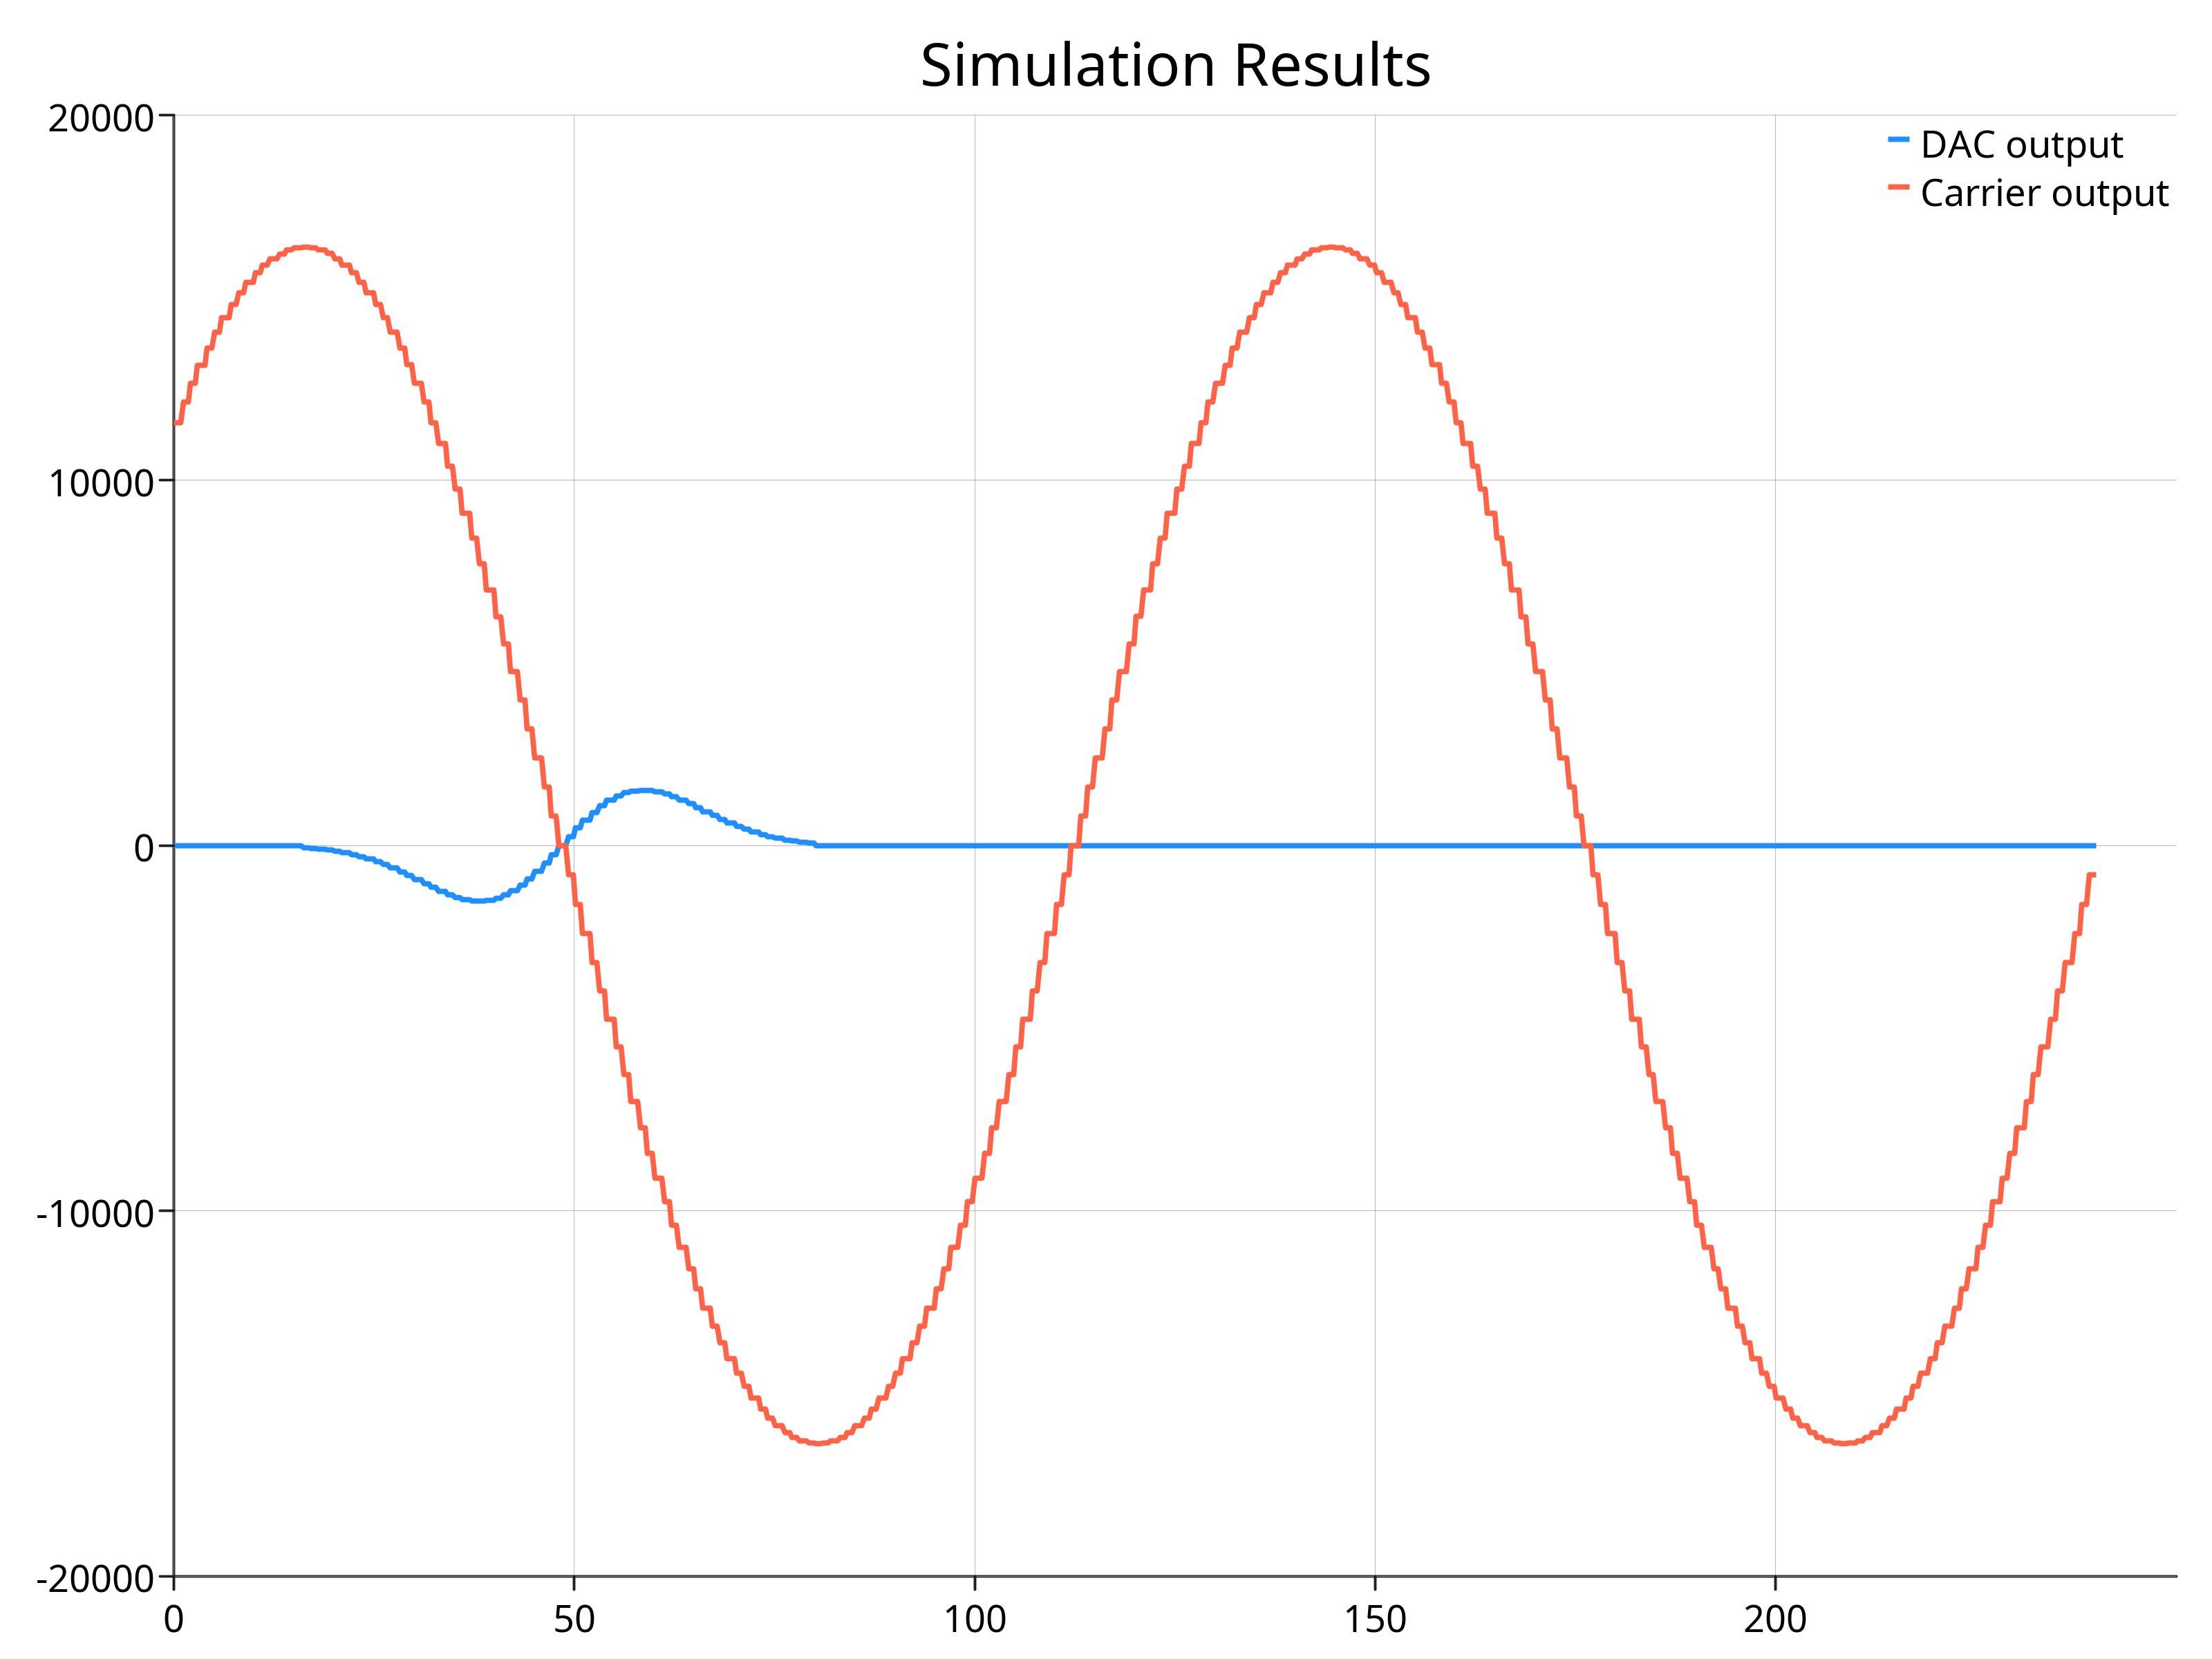

pngBytes: Array[Byte] = Array(
  -119,
  80,
  78,
  71,
  13,
  10,
  26,
  10,
  0,
  0,
  0,
  13,
  73,
  72,
  68,
  82,
  0,
  0,
  12,
  -128,
  0,
  0,
  9,
  96,
  8,
  6,
  0,
  0,
  0,
  74,
  -8,
  -83,
  93,
  0,
  0,
  -128,
  0,
  73,
...

In [6]:
val pngBytes = makeplot.make_plot(List(makeplot.LabeledData("DAC output", dac_output), makeplot.LabeledData("Carrier output", carrier_output)))
Image(pngBytes)